
# YOLO Bounding Box Visualizer

This notebook loads an image and a YOLO-format label `.txt` file and overlays the bounding boxes for quick visualization.

**YOLO format per line:**  
`<class_id> <x_center> <y_center> <width> <height>` — all values are **normalized** (0–1) relative to image width/height.

> Update the `IMAGE_PATH` and `LABEL_PATH` below to point to your files, then run the notebook from top to bottom.


In [ ]:

# --- Configuration ---
# Set these to your actual file paths
IMAGE_PATH = r"Weed-VLM Data Set\images\PfLADbLsruHijznKudNW_png_jpg.rf.5f5889c965b77a7e78d77c1105a5b1ff.jpg"   # e.g., "images/sample.jpg"
LABEL_PATH = r"Weed-VLM Data Set\labels\PfLADbLsruHijznKudNW_png_jpg.rf.5f5889c965b77a7e78d77c1105a5b1ff.txt"  # e.g., "labels/sample.txt"

# Optional: where to save the visualized image
OUTPUT_PATH = "visualized_bboxes.jpg"


In [7]:

from pathlib import Path
import math

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np


In [8]:

def load_yolo_labels(label_path):
    """Read YOLO label file and return a list of dicts per bbox.
    Each line: class_id x_center y_center width height (all normalized)
    Lines with 5+ numbers are supported; extra numbers (e.g. confidence) are ignored.
    Comments and empty lines are skipped.
    """
    labels = []
    p = Path(label_path)
    if not p.exists():
        raise FileNotFoundError(f"Label file not found: {label_path}")
    with p.open("r", encoding="utf-8") as f:
        for ln, line in enumerate(f, 1):
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split()
            if len(parts) < 5:
                print(f"Skipping malformed line {ln}: {line}")
                continue
            try:
                cls = int(float(parts[0]))
                x, y, w, h = map(float, parts[1:5])
                labels.append({
                    "class_id": cls,
                    "xc": x, "yc": y, "w": w, "h": h
                })
            except Exception as e:
                print(f"Skipping line {ln} due to parse error: {e} -> {line}")
    return labels


def yolo_to_xyxy(b, img_w, img_h):
    """Convert YOLO normalized bbox to absolute pixel coords (x1,y1,x2,y2)."""
    xc = b["xc"] * img_w
    yc = b["yc"] * img_h
    bw = b["w"] * img_w
    bh = b["h"] * img_h
    x1 = max(0, int(round(xc - bw/2)))
    y1 = max(0, int(round(yc - bh/2)))
    x2 = min(img_w - 1, int(round(xc + bw/2)))
    y2 = min(img_h - 1, int(round(yc + bh/2)))
    return x1, y1, x2, y2


def draw_bboxes_pil(image_path, labels, output_path=None, class_names=None, line_width=2):
    """Draw bboxes on an image using PIL. Optionally save to output_path.
    class_names: list or dict mapping class_id -> name (if provided, adds label text)
    """
    img = Image.open(image_path).convert("RGB")
    W, H = img.size
    draw = ImageDraw.Draw(img)

    # Try to load a default font; if unavailable, PIL uses a basic one
    try:
        font = ImageFont.truetype("arial.ttf", size=max(12, min(W, H)//50))
    except:
        font = ImageFont.load_default()

    # Distinct-ish colors cycle
    colors = [
        (255, 0, 0), (0, 255, 0), (0, 128, 255),
        (255, 165, 0), (255, 0, 255), (0, 255, 255),
        (128, 0, 128), (0, 0, 255), (128, 128, 0)
    ]

    for i, b in enumerate(labels):
        x1, y1, x2, y2 = yolo_to_xyxy(b, W, H)
        color = colors[b["class_id"] % len(colors)] if b.get("class_id") is not None else colors[i % len(colors)]
        # Rectangle
        for k in range(line_width):
            draw.rectangle([x1-k, y1-k, x2+k, y2+k], outline=color)
        # Label text (if names provided)
        if class_names is not None:
            name = class_names[b["class_id"]] if isinstance(class_names, (list, tuple)) and b["class_id"] < len(class_names) else (
                class_names.get(b["class_id"], str(b["class_id"])) if isinstance(class_names, dict) else str(b["class_id"])
            )
            text = f"{name}"
            # Text background box
            tw, th = draw.textbbox((0,0), text, font=font)[2:]
            tx, ty = x1, max(0, y1 - th - 2)
            draw.rectangle([tx, ty, tx + tw + 4, ty + th + 2], fill=(0,0,0))
            draw.text((tx + 2, ty + 1), text, fill=(255,255,255), font=font)

    if output_path:
        img.save(output_path)
    return img


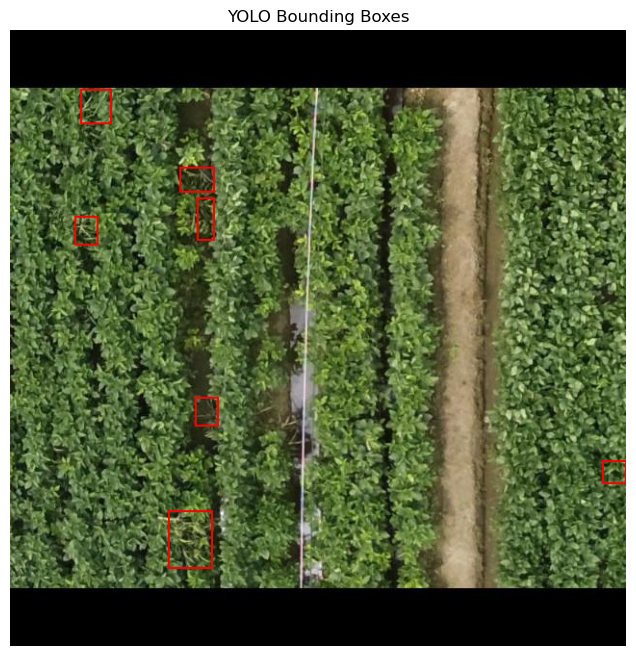

Saved visualized image to: visualized_bboxes.jpg


In [10]:

# --- Run ---
# Load labels
labels = load_yolo_labels(LABEL_PATH)

# Draw on image
_ = Path(IMAGE_PATH)
if not _.exists():
    raise FileNotFoundError(f"Image not found: {IMAGE_PATH}")

# Optional: define class names if you have multiple classes (index by class_id)
# class_names = {0: "object"}  # or ["object", "class1", ...]
class_names = None

vis_img = draw_bboxes_pil(IMAGE_PATH, labels, output_path=OUTPUT_PATH, class_names=class_names, line_width=2)

# Display
plt.figure(figsize=(10, 8))
plt.imshow(vis_img)
plt.axis("off")
plt.title("YOLO Bounding Boxes")
plt.show()

print(f"Saved visualized image to: {OUTPUT_PATH}")


## For Batch Visualization

In [ ]:
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import csv

# ---------------- Configuration ----------------
FOLDER = Path(r"Joint_Val")
OUTPUT_DIR = Path(r"Weed_Visualizer")
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

# Optional: map class_id -> name to show on boxes (or leave as None to skip labels)
# class_names = {0: "object"}
class_names = None

LINE_WIDTH = 2         # box line thickness
SAVE_SUFFIX = ""       # "" keeps the same filename; or set to "_vis"
SUMMARY_CSV = OUTPUT_DIR / "summary.csv"  # per-image counts

# -------------- Helpers --------------
def load_yolo_labels(label_path: Path):
    """Read YOLO label file and return a list of dicts per bbox.
    Each line: class_id x_center y_center width height (all normalized).
    Extra values per line are ignored. Comments/empty lines are skipped.
    """
    labels = []
    if not label_path.exists():
        return labels
    with label_path.open("r", encoding="utf-8") as f:
        for ln, line in enumerate(f, 1):
            s = line.strip()
            if not s or s.startswith("#"):
                continue
            parts = s.split()
            if len(parts) < 5:
                # Malformed line; skip
                continue
            try:
                cls = int(float(parts[0]))
                x, y, w, h = map(float, parts[1:5])
                labels.append({"class_id": cls, "xc": x, "yc": y, "w": w, "h": h})
            except Exception:
                # Skip parsing errors
                continue
    return labels

def yolo_to_xyxy(b, img_w, img_h):
    """Convert YOLO normalized bbox to absolute pixel coords (x1, y1, x2, y2)."""
    xc = b["xc"] * img_w
    yc = b["yc"] * img_h
    bw = b["w"] * img_w
    bh = b["h"] * img_h
    x1 = max(0, int(round(xc - bw / 2)))
    y1 = max(0, int(round(yc - bh / 2)))
    x2 = min(img_w - 1, int(round(xc + bw / 2)))
    y2 = min(img_h - 1, int(round(yc + bh / 2)))
    return x1, y1, x2, y2

def draw_bboxes_on_image(image_path: Path, labels, class_names=None, line_width=2):
    """Return a PIL Image with YOLO boxes drawn."""
    img = Image.open(image_path).convert("RGB")
    W, H = img.size
    draw = ImageDraw.Draw(img)

    # Try a readable font; fall back to default if unavailable
    try:
        font = ImageFont.truetype("arial.ttf", size=max(12, min(W, H) // 50))
    except:
        font = ImageFont.load_default()

    # A small color cycle
    colors = [
        (255, 0, 0), (0, 255, 0), (0, 128, 255),
        (255, 165, 0), (255, 0, 255), (0, 255, 255),
        (128, 0, 128), (0, 0, 255), (128, 128, 0)
    ]

    for i, b in enumerate(labels):
        x1, y1, x2, y2 = yolo_to_xyxy(b, W, H)
        color = colors[b["class_id"] % len(colors)] if b.get("class_id") is not None else colors[i % len(colors)]
        # Rectangle
        for k in range(line_width):
            draw.rectangle([x1 - k, y1 - k, x2 + k, y2 + k], outline=color)
        # Optional class name label
        if class_names is not None:
            if isinstance(class_names, (list, tuple)):
                name = class_names[b["class_id"]] if b["class_id"] < len(class_names) else str(b["class_id"])
            elif isinstance(class_names, dict):
                name = class_names.get(b["class_id"], str(b["class_id"]))
            else:
                name = str(b["class_id"])
            text = f"{name}"
            # Text background
            bbox = draw.textbbox((0, 0), text, font=font)
            tw, th = bbox[2], bbox[3]
            tx, ty = x1, max(0, y1 - th - 2)
            draw.rectangle([tx, ty, tx + tw + 4, ty + th + 2], fill=(0, 0, 0))
            draw.text((tx + 2, ty + 1), text, fill=(255, 255, 255), font=font)

    return img

# -------------- Batch Process --------------
def main():
    assert FOLDER.exists(), f"Folder does not exist: {FOLDER}"
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    images = [p for p in FOLDER.iterdir() if p.suffix.lower() in IMAGE_EXTS]
    images.sort()

    if not images:
        print(f"No images found in {FOLDER} with extensions: {sorted(IMAGE_EXTS)}")
        return

    print(f"Found {len(images)} image(s). Writing annotated copies to: {OUTPUT_DIR}")

    summary_rows = [["filename", "num_boxes", "label_file_found"]]
    processed = 0
    missing_labels = 0

    for img_path in images:
        label_path = img_path.with_suffix(".txt")
        labels = load_yolo_labels(label_path)
        if not label_path.exists():
            missing_labels += 1

        # Draw and save
        vis_img = draw_bboxes_on_image(img_path, labels, class_names=class_names, line_width=LINE_WIDTH)
        out_name = (img_path.stem + SAVE_SUFFIX + img_path.suffix)
        out_path = OUTPUT_DIR / out_name
        vis_img.save(out_path, quality=95)
        summary_rows.append([img_path.name, len(labels), label_path.exists()])
        processed += 1

        if processed % 25 == 0:
            print(f"Processed {processed}/{len(images)}...")

    # Write summary CSV
    with SUMMARY_CSV.open("w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerows(summary_rows)

    print(f"Done. Processed {processed} image(s).")
    if missing_labels:
        print(f"Note: {missing_labels} image(s) had no matching .txt label file.")
    print(f"Summary CSV: {SUMMARY_CSV}")

if __name__ == "__main__":
    main()


Found 441 image(s). Writing annotated copies to: D:\Khalifa University 2024\Conferences - Research\Al-Ain 2025\Weed_Visualizer
Processed 25/441...
Processed 50/441...
Processed 75/441...
Processed 100/441...
Processed 125/441...
Processed 150/441...
Processed 175/441...
Processed 200/441...
Processed 225/441...
Processed 250/441...
Processed 275/441...
Processed 300/441...
Processed 325/441...
Processed 350/441...
Processed 375/441...
Processed 400/441...
Processed 425/441...
Done. Processed 441 image(s).
Summary CSV: D:\Khalifa University 2024\Conferences - Research\Al-Ain 2025\Weed_Visualizer\summary.csv
